In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
%matplotlib inline

In [3]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [4]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [5]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

# 1. Data

In [6]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=True, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index
df_index_return = strategy.ret

2020-06-23 09:48:40,736 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-06-23 09:48:40,740 - EPM - INFO - [STEP 1] LOAD DATA
2020-06-23 09:48:40,741 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-06-23 09:48:40,757 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-06-23 09:49:01,471 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-06-23 09:49:18,028 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-06-23 09:50:16,471 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [23]:
indiv_momentum_lst = [21, 42, 63, 126, 252]

In [24]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

In [25]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

In [26]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [27]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

In [28]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [29]:
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# 2. EPM

In [32]:
from EPM import EPM

In [33]:
epm = EPM(strategy_name="EPM", asset_type="EQUITY")
epm.load_index_and_return(from_db=True, save_file=False)
epm.load_strategy_data(table='datastream', origin='EPS')
epm.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
epm.calculate_signal(minobs1=52, longlen=52, longlen2=13, shortlen=2, CS=0.35)
epm.set_portfolio_parameter(cs_strategy_type='notional')
epm.make_portfolio()

2020-04-28 09:39:42,896 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-04-28 09:39:42,896 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-04-28 09:39:42,896 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-04-28 09:39:42,896 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-04-28 09:39:42,896 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-04-28 09:39:42,896 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-04-28 09:39:42,900 - EPM - INFO - [STEP 1] LOAD DATA
2020-04-28 09:39:42,900 - EPM - INFO - [STEP 1] LOAD DATA
2020-04-28 09:39:42,900 - EPM - INFO - [STEP 1] LOAD DATA
2020-04-28 09:39:42,900 - EPM - INFO - [STEP 1] LOAD DATA
2020-04-28 09:39:42,900 - EPM - INFO - [STEP 1] LOAD DATA
2020-04-28 09:39:42,900 - EPM - INFO - [STEP 1] LOAD DATA
2020-04-28 09:39:42,903 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-04-28 09:39:42,903 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-04-28 09:39:42,903 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-04-28 09:39:42,90

2020-04-28 09:40:57,918 - EPM - INFO - [STEP 3 - 2] SIGNAL 3. SHORT TERM  MOMENTUM
2020-04-28 09:40:57,918 - EPM - INFO - [STEP 3 - 2] SIGNAL 3. SHORT TERM  MOMENTUM
2020-04-28 09:40:57,918 - EPM - INFO - [STEP 3 - 2] SIGNAL 3. SHORT TERM  MOMENTUM
2020-04-28 09:40:57,918 - EPM - INFO - [STEP 3 - 2] SIGNAL 3. SHORT TERM  MOMENTUM
2020-04-28 09:40:57,918 - EPM - INFO - [STEP 3 - 2] SIGNAL 3. SHORT TERM  MOMENTUM
2020-04-28 09:40:58,237 - EPM - INFO - [STEP 3 - 2 - 2] SIGNAL 4. SHORT TERM MOMENTUM PERCENTAGE OF UP DAY
2020-04-28 09:40:58,237 - EPM - INFO - [STEP 3 - 2 - 2] SIGNAL 4. SHORT TERM MOMENTUM PERCENTAGE OF UP DAY
2020-04-28 09:40:58,237 - EPM - INFO - [STEP 3 - 2 - 2] SIGNAL 4. SHORT TERM MOMENTUM PERCENTAGE OF UP DAY
2020-04-28 09:40:58,237 - EPM - INFO - [STEP 3 - 2 - 2] SIGNAL 4. SHORT TERM MOMENTUM PERCENTAGE OF UP DAY
2020-04-28 09:40:58,237 - EPM - INFO - [STEP 3 - 2 - 2] SIGNAL 4. SHORT TERM MOMENTUM PERCENTAGE OF UP DAY
2020-04-28 09:40:58,237 - EPM - INFO - [STEP 3 - 2

2020-04-28 09:41:56,861 - EPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2020-04-28 09:41:57,904 - EPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2020-04-28 09:41:57,904 - EPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2020-04-28 09:41:57,904 - EPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2020-04-28 09:41:57,904 - EPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2020-04-28 09:41:57,904 - EPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2020-04-28 09:41:57,904 - EPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2020-04-28 09:41:57,910 - EPM - INFO - [STEP 5 - 4] SAVE POSITION
2020-04-28 09:41:57,910 - EPM - INFO - [STEP 5 - 4] SAVE POSITION
2020-04-28 09:41:57,910 - EPM - INFO - [STEP 5 - 4] SAVE POSITION
2020-04-28 09:41:57,910 - EPM - INFO - [STEP 5 - 4] SAVE POSITION
2020-04-28 09:41:57,910 - EPM - INFO - [STEP 5 - 4] SAVE POSITION
2020-04-28 09:41:57,910 - EPM - INFO - [STEP 5 - 4] SAVE POSITION


In [119]:
start_date = '2011-01-01'
end_date = '2019-12-31'

# get r results
epm_comp_df = pd.read_csv('../../strategy/check/past/epm.csv', header=0, index_col=0, parse_dates=True)
epm_lag_comp_df = pd.read_csv('../../strategy/check/past/epm_lag.csv', header=0, index_col=0, parse_dates=True)

In [120]:
tester = Tester(epm)
tester.set_period(start=start_date, end=end_date)
tester.run(use_bt=False)

2020-04-28 10:23:25,407 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 10:23:25,407 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 10:23:25,407 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 10:23:25,407 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 10:23:25,407 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 10:23:25,407 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 10:23:25,411 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 10:23:25,411 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 10:23:25,411 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 10:23:25,411 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 10:23:25,411 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 10:23:25,411 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 10:23:26,347 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-04-28 10:23:26,347 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONA

In [121]:
to_plot = (1.+ epm_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 3. DataRobot

In [57]:
df_robot = pd.read_csv('./equity_momentum_result.csv')

In [63]:
df_robot['tdate'] = pd.to_datetime(df_robot['tdate'])

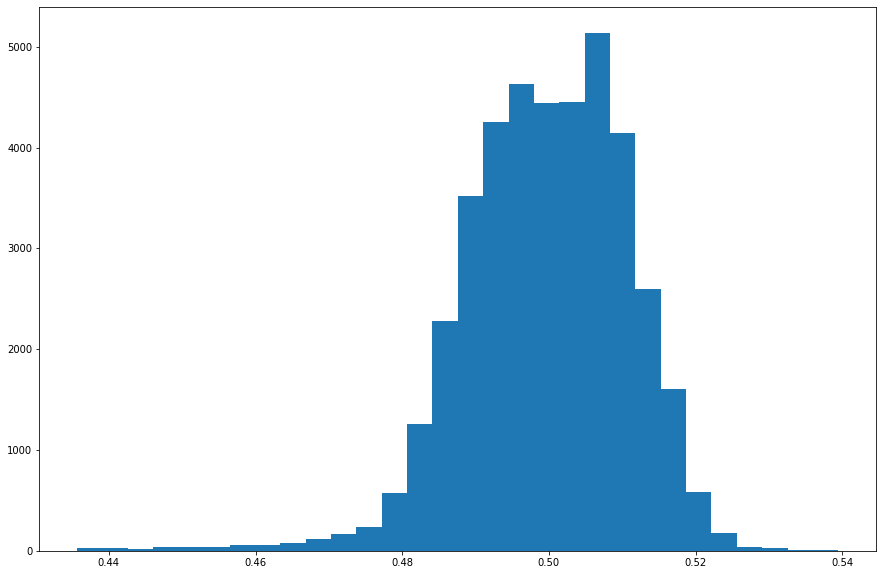

In [64]:
plt.figure(figsize=(15,10))
plt.hist(df_robot["Training Prediction"], bins=30)
plt.show()

In [66]:
df_pred = pd.pivot_table(df_robot, columns='ticker', index='tdate', values='Training Prediction')

In [68]:
df_pred = df_pred['2011':'2019']

In [71]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [74]:
tester = Tester(strategy)
strategy.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2020-04-28 09:55:17,478 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-04-28 09:55:17,478 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-04-28 09:55:17,478 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-04-28 09:55:17,478 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-04-28 09:55:17,478 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-04-28 09:55:17,478 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-04-28 09:55:17,482 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-04-28 09:55:17,482 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-04-28 09:55:17,482 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-04-28 09:55:17,482 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-04-28 09:55:17,482 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-04-28 09:55:17,482 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-04-28 09:55:17,485 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-04-28 09:55:17,485 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-04-28 09:55:17,485 - EP

In [91]:
strategy.index.columns

Index(['CAC', 'AEX', 'SPX', 'DAX', 'HSI', 'IBEX', 'NKY', 'TSX', 'OMX', 'SG',
       'SMI', 'MIB', 'AS51', 'FTSE'],
      dtype='object', name='ticker')

In [75]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run(use_bt=False)

2020-04-28 09:56:11,687 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 09:56:11,687 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 09:56:11,687 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 09:56:11,687 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 09:56:11,687 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 09:56:11,687 - EPM - INFO - [STEP 6] START BACKTEST
2020-04-28 09:56:11,692 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 09:56:11,692 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 09:56:11,692 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 09:56:11,692 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 09:56:11,692 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 09:56:11,692 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-04-28 09:56:12,656 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-04-28 09:56:12,656 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONA

In [122]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [123]:
to_plot.columns

Index(['TS', 'CS', 'TS_python', 'CS_python', 'CS_ML'], dtype='object')

In [126]:
to_plot = to_plot.rename(columns={"CS_python": 'EPM', 'CS_ML': "EPM_ML"})

In [128]:
to_plot[['EPM', 'EPM_ML']].iplot()

In [129]:
df_result = pd.concat([epm.CS_summary, strategy.CS_summary], axis=1)

In [130]:
df_result.columns = ["EPM", "EPM_ML"]

In [131]:
df_result

EPM    EPM_ML
TURNOVER   4.414866  3.648508
MDD       -0.049811 -0.036831
CAGR      -0.000339  0.012422
CAGR_TR   -0.005464  0.008747
VOL        0.001306  0.001299
SHARPE    -0.005634  0.597810
SHARPE_TR -0.248502  0.424791

# 2.

In [34]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 4 * 3
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [35]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2007-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2008-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [36]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.598067	valid_1's binary_logloss: 0.598127
[20]	training's binary_logloss: 0.597873	valid_1's binary_logloss: 0.597979
[30]	training's binary_logloss: 0.59767	valid_1's binary_logloss: 0.597874
[40]	training's binary_logloss: 0.597479	valid_1's binary_logloss: 0.597767
[50]	training's binary_logloss: 0.597274	valid_1's binary_logloss: 0.597706
[60]	training's binary_logloss: 0.597082	valid_1's binary_logloss: 0.597613
[70]	training's binary_logloss: 0.596899	valid_1's binary_logloss: 0.597596
[80]	training's binary_logloss: 0.596711	valid_1's binary_logloss: 0.597501
[90]	training's binary_logloss: 0.596526	valid_1's binary_logloss: 0.597458
[100]	training's binary_logloss: 0.59634	valid_1's binary_logloss: 0.597408
[110]	training's binary_logloss: 0.596154	valid_1's binary_logloss: 0.597364
[120]	training's binary_logloss: 0.595978	valid_1's binary_logloss: 0.597318
[130]	training's binary_l

In [37]:
test_pred = model.predict(df_test_x.values)

In [38]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [39]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [40]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_rebalance_period(freq='month') 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-11-21 16:40:38,951 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:38,951 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:38,951 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:38,954 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:38,954 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:38,954 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:38,956 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:38,956 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:38,956 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:39,010 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:39,010 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:39,010 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:39,012 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:39,012 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:39,012 - EPM - INFO - [STEP 4] SET PORTFOLIO

In [41]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run()

2019-11-21 16:41:04,903 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:04,903 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:04,903 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:04,905 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:04,905 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:04,905 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:05,750 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:05,750 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:05,750 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [42]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [43]:
to_plot.iplot()

In [44]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

In [45]:
result

0         1         2         3
TURNOVER   2.175536  0.834014  3.015364  2.657037
MDD       -0.028668 -0.040567 -0.029786 -0.037866
CAGR       0.007017  0.002591  0.009509  0.003007
CAGR_TR   -0.003191 -0.000753 -0.004625 -0.009755
VOL        0.001356  0.001196  0.001366  0.001355
SHARPE     0.329635  0.143223  0.439195  0.147719
SHARPE_TR -0.134812 -0.029428 -0.198392 -0.435804

In [46]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

# 3. 

In [47]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [48]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [49]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [50]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692967	valid_1's binary_logloss: 0.69304
[20]	training's binary_logloss: 0.692788	valid_1's binary_logloss: 0.692944
[30]	training's binary_logloss: 0.692606	valid_1's binary_logloss: 0.69287
[40]	training's binary_logloss: 0.692425	valid_1's binary_logloss: 0.692787
[50]	training's binary_logloss: 0.692249	valid_1's binary_logloss: 0.692698
[60]	training's binary_logloss: 0.692067	valid_1's binary_logloss: 0.692636
[70]	training's binary_logloss: 0.69189	valid_1's binary_logloss: 0.692589
[80]	training's binary_logloss: 0.691713	valid_1's binary_logloss: 0.692539
[90]	training's binary_logloss: 0.691529	valid_1's binary_logloss: 0.6925
[100]	training's binary_logloss: 0.691351	valid_1's binary_logloss: 0.692444
[110]	training's binary_logloss: 0.691174	valid_1's binary_logloss: 0.692424
[120]	training's binary_logloss: 0.691003	valid_1's binary_logloss: 0.69239
[130]	training's binary_loglo

[70]	training's binary_logloss: 0.69225	valid_1's binary_logloss: 0.693149
[80]	training's binary_logloss: 0.692123	valid_1's binary_logloss: 0.693152
[90]	training's binary_logloss: 0.692	valid_1's binary_logloss: 0.693157
[100]	training's binary_logloss: 0.691872	valid_1's binary_logloss: 0.693162
[110]	training's binary_logloss: 0.691744	valid_1's binary_logloss: 0.693166
[120]	training's binary_logloss: 0.691619	valid_1's binary_logloss: 0.693174
[130]	training's binary_logloss: 0.691499	valid_1's binary_logloss: 0.693173
[140]	training's binary_logloss: 0.691373	valid_1's binary_logloss: 0.693172
[150]	training's binary_logloss: 0.691252	valid_1's binary_logloss: 0.693178
[160]	training's binary_logloss: 0.691126	valid_1's binary_logloss: 0.693184
[170]	training's binary_logloss: 0.691008	valid_1's binary_logloss: 0.693193
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.692161	valid_1's binary_logloss: 0.693148
Training until validation scores don't improve fo

[480]	training's binary_logloss: 0.688386	valid_1's binary_logloss: 0.692717
[490]	training's binary_logloss: 0.688287	valid_1's binary_logloss: 0.692702
[500]	training's binary_logloss: 0.688195	valid_1's binary_logloss: 0.692698
[510]	training's binary_logloss: 0.688102	valid_1's binary_logloss: 0.692689
[520]	training's binary_logloss: 0.688014	valid_1's binary_logloss: 0.692681
[530]	training's binary_logloss: 0.687922	valid_1's binary_logloss: 0.692678
[540]	training's binary_logloss: 0.687829	valid_1's binary_logloss: 0.692683
[550]	training's binary_logloss: 0.687745	valid_1's binary_logloss: 0.692686
[560]	training's binary_logloss: 0.687654	valid_1's binary_logloss: 0.692682
[570]	training's binary_logloss: 0.687557	valid_1's binary_logloss: 0.692672
[580]	training's binary_logloss: 0.687469	valid_1's binary_logloss: 0.692672
[590]	training's binary_logloss: 0.687384	valid_1's binary_logloss: 0.692681
[600]	training's binary_logloss: 0.687295	valid_1's binary_logloss: 0.692669

In [51]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

In [52]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [53]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-11-21 16:41:19,926 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:19,926 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:19,926 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:19,926 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:19,929 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:19,929 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:19,929 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:19,929 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:19,931 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:19,931 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:19,931 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:19,931 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [54]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month') 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-11-21 16:41:20,019 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:20,019 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:20,019 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:20,019 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:20,021 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:20,021 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:20,021 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:20,021 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:20,023 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:20,023 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:20,023 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:20,023 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:20,025 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:41:20,025 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:41:20,025 - EPM - INFO -

In [55]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

2019-11-21 16:41:44,461 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:44,461 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:44,461 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:44,461 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:44,463 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:44,463 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:44,463 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:44,463 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:44,984 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:44,984 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:44,984 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:44,984 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [56]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [57]:
to_plot.iplot()

In [58]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [59]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [60]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER  CS_ML_ROLLING
TURNOVER    2.175536   0.834014  3.015364     2.657037       2.944303
MDD        -0.028668  -0.040567 -0.029786    -0.037866      -0.036348
CAGR        0.007017   0.002591  0.009509     0.003007       0.002640
CAGR_TR    -0.003191  -0.000753 -0.004625    -0.009755      -0.009400
VOL         0.001356   0.001196  0.001366     0.001355       0.001373
SHARPE      0.329635   0.143223  0.439195     0.147719       0.129574
SHARPE_TR  -0.134812  -0.029428 -0.198392    -0.435804      -0.413774

# 4.

In [61]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [62]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.59806	valid_1's binary_logloss: 0.59813
[20]	training's binary_logloss: 0.597871	valid_1's binary_logloss: 0.597995
[30]	training's binary_logloss: 0.597674	valid_1's binary_logloss: 0.597892
[40]	training's binary_logloss: 0.597477	valid_1's binary_logloss: 0.597796
[50]	training's binary_logloss: 0.597283	valid_1's binary_logloss: 0.597732
[60]	training's binary_logloss: 0.59709	valid_1's binary_logloss: 0.597645
[70]	training's binary_logloss: 0.596888	valid_1's binary_logloss: 0.597553
[80]	training's binary_logloss: 0.596705	valid_1's binary_logloss: 0.597492
[90]	training's binary_logloss: 0.596525	valid_1's binary_logloss: 0.597461
[100]	training's binary_logloss: 0.596336	valid_1's binary_logloss: 0.597398
[110]	training's binary_logloss: 0.596134	valid_1's binary_logloss: 0.597337
[120]	training's binary_logloss: 0.595957	valid_1's binary_logloss: 0.597303
[130]	training's binary_lo

[700]	training's binary_logloss: 0.587972	valid_1's binary_logloss: 0.59609
[710]	training's binary_logloss: 0.587861	valid_1's binary_logloss: 0.596066
[720]	training's binary_logloss: 0.587753	valid_1's binary_logloss: 0.596066
[730]	training's binary_logloss: 0.587637	valid_1's binary_logloss: 0.596039
[740]	training's binary_logloss: 0.587524	valid_1's binary_logloss: 0.596026
[750]	training's binary_logloss: 0.587401	valid_1's binary_logloss: 0.596009
[760]	training's binary_logloss: 0.587289	valid_1's binary_logloss: 0.596005
[770]	training's binary_logloss: 0.587179	valid_1's binary_logloss: 0.595988
[780]	training's binary_logloss: 0.587066	valid_1's binary_logloss: 0.595999
[790]	training's binary_logloss: 0.586939	valid_1's binary_logloss: 0.59599
[800]	training's binary_logloss: 0.586836	valid_1's binary_logloss: 0.595996
[810]	training's binary_logloss: 0.586713	valid_1's binary_logloss: 0.596
[820]	training's binary_logloss: 0.586599	valid_1's binary_logloss: 0.595987
[830

[690]	training's binary_logloss: 0.58862	valid_1's binary_logloss: 0.597446
[700]	training's binary_logloss: 0.588516	valid_1's binary_logloss: 0.59744
[710]	training's binary_logloss: 0.588408	valid_1's binary_logloss: 0.59743
[720]	training's binary_logloss: 0.588301	valid_1's binary_logloss: 0.597424
[730]	training's binary_logloss: 0.588192	valid_1's binary_logloss: 0.597418
[740]	training's binary_logloss: 0.588093	valid_1's binary_logloss: 0.59741
[750]	training's binary_logloss: 0.587983	valid_1's binary_logloss: 0.597395
[760]	training's binary_logloss: 0.58788	valid_1's binary_logloss: 0.597386
[770]	training's binary_logloss: 0.587776	valid_1's binary_logloss: 0.597381
[780]	training's binary_logloss: 0.587669	valid_1's binary_logloss: 0.597375
[790]	training's binary_logloss: 0.587558	valid_1's binary_logloss: 0.597359
[800]	training's binary_logloss: 0.587462	valid_1's binary_logloss: 0.597351
[810]	training's binary_logloss: 0.587357	valid_1's binary_logloss: 0.597343
[820

[750]	training's binary_logloss: 0.588538	valid_1's binary_logloss: 0.596527
[760]	training's binary_logloss: 0.588436	valid_1's binary_logloss: 0.596504
[770]	training's binary_logloss: 0.588336	valid_1's binary_logloss: 0.596489
[780]	training's binary_logloss: 0.588234	valid_1's binary_logloss: 0.59647
[790]	training's binary_logloss: 0.58812	valid_1's binary_logloss: 0.596464
[800]	training's binary_logloss: 0.588029	valid_1's binary_logloss: 0.596443
[810]	training's binary_logloss: 0.587928	valid_1's binary_logloss: 0.596413
[820]	training's binary_logloss: 0.587827	valid_1's binary_logloss: 0.596403
[830]	training's binary_logloss: 0.587736	valid_1's binary_logloss: 0.596386
[840]	training's binary_logloss: 0.587629	valid_1's binary_logloss: 0.596373
[850]	training's binary_logloss: 0.587538	valid_1's binary_logloss: 0.596352
[860]	training's binary_logloss: 0.587436	valid_1's binary_logloss: 0.596336
[870]	training's binary_logloss: 0.587338	valid_1's binary_logloss: 0.59632
[8

[1890]	training's binary_logloss: 0.578571	valid_1's binary_logloss: 0.595681
[1900]	training's binary_logloss: 0.578494	valid_1's binary_logloss: 0.595681
[1910]	training's binary_logloss: 0.57841	valid_1's binary_logloss: 0.595682
[1920]	training's binary_logloss: 0.578336	valid_1's binary_logloss: 0.595676
[1930]	training's binary_logloss: 0.578262	valid_1's binary_logloss: 0.595673
[1940]	training's binary_logloss: 0.578175	valid_1's binary_logloss: 0.595678
[1950]	training's binary_logloss: 0.578096	valid_1's binary_logloss: 0.595667
[1960]	training's binary_logloss: 0.578009	valid_1's binary_logloss: 0.595673
[1970]	training's binary_logloss: 0.57794	valid_1's binary_logloss: 0.59567
[1980]	training's binary_logloss: 0.577876	valid_1's binary_logloss: 0.595669
[1990]	training's binary_logloss: 0.577798	valid_1's binary_logloss: 0.59567
[2000]	training's binary_logloss: 0.577729	valid_1's binary_logloss: 0.595668
[2010]	training's binary_logloss: 0.577656	valid_1's binary_logloss:

[900]	training's binary_logloss: 0.58734	valid_1's binary_logloss: 0.596932
[910]	training's binary_logloss: 0.587244	valid_1's binary_logloss: 0.596912
[920]	training's binary_logloss: 0.587148	valid_1's binary_logloss: 0.596905
[930]	training's binary_logloss: 0.587051	valid_1's binary_logloss: 0.596896
[940]	training's binary_logloss: 0.586953	valid_1's binary_logloss: 0.596879
[950]	training's binary_logloss: 0.586866	valid_1's binary_logloss: 0.596867
[960]	training's binary_logloss: 0.586768	valid_1's binary_logloss: 0.596847
[970]	training's binary_logloss: 0.586671	valid_1's binary_logloss: 0.596831
[980]	training's binary_logloss: 0.586568	valid_1's binary_logloss: 0.596819
[990]	training's binary_logloss: 0.586483	valid_1's binary_logloss: 0.596807
[1000]	training's binary_logloss: 0.586398	valid_1's binary_logloss: 0.5968
[1010]	training's binary_logloss: 0.586298	valid_1's binary_logloss: 0.596787
[1020]	training's binary_logloss: 0.586208	valid_1's binary_logloss: 0.59677


[2000]	training's binary_logloss: 0.578536	valid_1's binary_logloss: 0.596276
[2010]	training's binary_logloss: 0.578472	valid_1's binary_logloss: 0.596274
[2020]	training's binary_logloss: 0.578406	valid_1's binary_logloss: 0.596274
[2030]	training's binary_logloss: 0.578338	valid_1's binary_logloss: 0.596278
Early stopping, best iteration is:
[1932]	training's binary_logloss: 0.579015	valid_1's binary_logloss: 0.596266
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.59812	valid_1's binary_logloss: 0.598245
[20]	training's binary_logloss: 0.597967	valid_1's binary_logloss: 0.598217
[30]	training's binary_logloss: 0.597825	valid_1's binary_logloss: 0.59819
[40]	training's binary_logloss: 0.597671	valid_1's binary_logloss: 0.598172
[50]	training's binary_logloss: 0.597521	valid_1's binary_logloss: 0.598141
[60]	training's binary_logloss: 0.597361	valid_1's binary_logloss: 0.598121
[70]	training's binary_logloss: 0.597205	valid_1's binary_l

[1020]	training's binary_logloss: 0.587163	valid_1's binary_logloss: 0.596894
[1030]	training's binary_logloss: 0.587073	valid_1's binary_logloss: 0.596887
[1040]	training's binary_logloss: 0.586978	valid_1's binary_logloss: 0.596867
[1050]	training's binary_logloss: 0.586894	valid_1's binary_logloss: 0.596849
[1060]	training's binary_logloss: 0.586806	valid_1's binary_logloss: 0.596839
[1070]	training's binary_logloss: 0.586716	valid_1's binary_logloss: 0.596827
[1080]	training's binary_logloss: 0.586627	valid_1's binary_logloss: 0.596822
[1090]	training's binary_logloss: 0.586543	valid_1's binary_logloss: 0.596804
[1100]	training's binary_logloss: 0.586455	valid_1's binary_logloss: 0.596789
[1110]	training's binary_logloss: 0.586365	valid_1's binary_logloss: 0.596779
[1120]	training's binary_logloss: 0.586277	valid_1's binary_logloss: 0.596775
[1130]	training's binary_logloss: 0.586196	valid_1's binary_logloss: 0.596772
[1140]	training's binary_logloss: 0.586109	valid_1's binary_logl

[2170]	training's binary_logloss: 0.578593	valid_1's binary_logloss: 0.596317
[2180]	training's binary_logloss: 0.578528	valid_1's binary_logloss: 0.596316
[2190]	training's binary_logloss: 0.578451	valid_1's binary_logloss: 0.596314
[2200]	training's binary_logloss: 0.578382	valid_1's binary_logloss: 0.596312
Early stopping, best iteration is:
[2103]	training's binary_logloss: 0.579072	valid_1's binary_logloss: 0.596304
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.598115	valid_1's binary_logloss: 0.598249
[20]	training's binary_logloss: 0.597961	valid_1's binary_logloss: 0.598231
[30]	training's binary_logloss: 0.597815	valid_1's binary_logloss: 0.598211
[40]	training's binary_logloss: 0.59766	valid_1's binary_logloss: 0.598194
[50]	training's binary_logloss: 0.597509	valid_1's binary_logloss: 0.598172
[60]	training's binary_logloss: 0.597359	valid_1's binary_logloss: 0.598153
[70]	training's binary_logloss: 0.597204	valid_1's binary_

[240]	training's binary_logloss: 0.595012	valid_1's binary_logloss: 0.598058
[250]	training's binary_logloss: 0.594884	valid_1's binary_logloss: 0.598056
[260]	training's binary_logloss: 0.594767	valid_1's binary_logloss: 0.598047
[270]	training's binary_logloss: 0.594644	valid_1's binary_logloss: 0.598047
[280]	training's binary_logloss: 0.59453	valid_1's binary_logloss: 0.59804
[290]	training's binary_logloss: 0.59442	valid_1's binary_logloss: 0.598039
[300]	training's binary_logloss: 0.594312	valid_1's binary_logloss: 0.598037
[310]	training's binary_logloss: 0.5942	valid_1's binary_logloss: 0.598036
[320]	training's binary_logloss: 0.594084	valid_1's binary_logloss: 0.598035
[330]	training's binary_logloss: 0.593966	valid_1's binary_logloss: 0.598041
[340]	training's binary_logloss: 0.593853	valid_1's binary_logloss: 0.598039
[350]	training's binary_logloss: 0.593747	valid_1's binary_logloss: 0.598047
[360]	training's binary_logloss: 0.593634	valid_1's binary_logloss: 0.598042
[370

In [63]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [64]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [65]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-11-21 16:42:14,585 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:42:14,585 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:42:14,585 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:42:14,585 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:42:14,585 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:42:14,588 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:42:14,588 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:42:14,588 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:42:14,588 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:42:14,588 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:42:14,590 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:42:14,590 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:42:14,590 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:42:14,590 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:42:14,590 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [66]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-11-21 16:42:14,654 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:42:14,654 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:42:14,654 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:42:14,654 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:42:14,654 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:42:14,655 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:42:14,655 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:42:14,655 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:42:14,655 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:42:14,655 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:42:14,657 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:42:14,657 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:42:14,657 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:42:14,657 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:42:14,657 - EPM - INFO - [STE

In [67]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

2019-11-21 16:42:32,007 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:42:32,007 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:42:32,007 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:42:32,007 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:42:32,007 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:42:32,009 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:42:32,009 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:42:32,009 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:42:32,009 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:42:32,009 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:42:32,562 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:42:32,562 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:42:32,562 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:42:32,562 - EPM - INFO - [STEP 6 - 2] BACKT

In [68]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [69]:
to_plot.iplot()

In [70]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [71]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [72]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER  CS_ML_ROLLING  \
TURNOVER    2.175536   0.834014  3.015364     2.657037       2.944303   
MDD        -0.028668  -0.040567 -0.029786    -0.037866      -0.036348   
CAGR        0.007017   0.002591  0.009509     0.003007       0.002640   
CAGR_TR    -0.003191  -0.000753 -0.004625    -0.009755      -0.009400   
VOL         0.001356   0.001196  0.001366     0.001355       0.001373   
SHARPE      0.329635   0.143223  0.439195     0.147719       0.129574   
SHARPE_TR  -0.134812  -0.029428 -0.198392    -0.435804      -0.413774   

           CS_ML_UPPER_ROLING  
TURNOVER             3.071491  
MDD                 -0.037613  
CAGR                 0.009687  
CAGR_TR             -0.003651  
VOL                  0.001378  
SHARPE               0.443351  
SHARPE_TR           -0.152523